In [1]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, fbeta_score

from hyperopt import hp
import hyperopt.pyll
from hyperopt.pyll import scope
from hyperopt import STATUS_OK
from hyperopt import fmin, tpe, Trials

from datetime import datetime

import sys
sys.path.append('../../Pipeline')

from ml_utils import *


In [2]:
original_df = pd.read_csv('../../../data/cleandata/Info pluviometricas/Merged Data/repaired.csv', sep = ';')
original_df['Data_Hora'] = pd.to_datetime(original_df['Data_Hora'])
original_df['Date'] = original_df['Data_Hora'].dt.date

In [3]:
interest_cols = list({c.split('_')[0] for c in original_df.columns if '_error' in c})
interest_cols.remove('TemperaturaInterna')
interest_cols.remove('SensacaoTermica')

# Group Stations - Mean 

In [4]:
for c in interest_cols:
    original_df[c] = (original_df[c+'_0'] + original_df[c+'_1'] +
                      original_df[c+'_2'] + original_df[c+'_3'] + original_df[c+'_4'])/5 

## Plot data

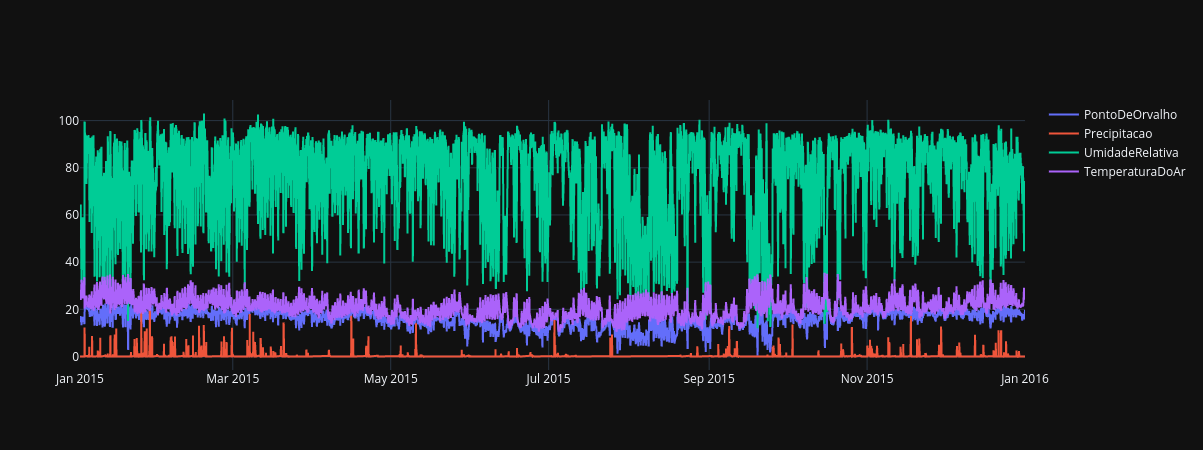

In [5]:
df_plot = original_df[original_df.Data_Hora.dt.year == 2015]

fig = go.Figure(layout=dict(template = 'plotly_dark'))

for col in ['PontoDeOrvalho', 'Precipitacao', 'UmidadeRelativa', 'TemperaturaDoAr']:    
    fig.add_trace(go.Scatter(
        x = df_plot['Data_Hora'],
        y = df_plot[col],
        name = col,
                            )
                 )
fig.show()

# Feature Engineering

In [6]:
interest_cols += ['Diff_Temp_POrvalho']
original_df['Diff_Temp_POrvalho'] = original_df['TemperaturaDoAr'] -  original_df['PontoDeOrvalho']

In [7]:
hours = 6
sum = original_df['Precipitacao'].rolling(hours*4).sum()

## Has Rain

In [8]:

has_rain_treshold = 10
precipitacao_sum = original_df.loc[:, ['Date', 'Precipitacao']].groupby('Date').sum()
precipitacao_sum.loc[:, 'Rain_Today'] = precipitacao_sum['Precipitacao'] > has_rain_treshold
precipitacao_sum.loc[:, 'Rain_Next_Day'] = precipitacao_sum.loc[:, 'Rain_Today'].shift(-1)
precipitacao_sum = precipitacao_sum.dropna()

precipitacao_sum.index = pd.to_datetime(precipitacao_sum.index, yearfirst=True)
precipitacao_sum.head()


Precipitacao  Rain_Today Rain_Next_Day
Date                                              
2011-01-01      1.520000       False          True
2011-01-02    139.120000        True          True
2011-01-03     65.875571        True          True
2011-01-04     62.360000        True          True
2011-01-05     11.960000        True          True

# Create Datewise DataFrame 

In [9]:
df = original_df[interest_cols + ['Date' , 'Data_Hora'] ]
df = df.set_index('Data_Hora')

In [10]:
unique_dates = df.index.round('D').unique()
df_date = pd.DataFrame(precipitacao_sum.index, columns = ['Date'])

In [11]:
df_date = df_date.merge(precipitacao_sum.loc[:, ['Rain_Today','Rain_Next_Day']], on = 'Date')
df_date = df_date.set_index('Date')

## Simple Metrics

In [12]:

sum_date = df[interest_cols + ['Date']].groupby('Date').sum()
sum_date.columns = [c + '_sum' for c in sum_date.columns]

median_date = df[interest_cols + ['Date']].groupby('Date').median()
median_date.columns = [c + '_median' for c in median_date.columns]

mean_date = df[interest_cols + ['Date']].groupby('Date').mean()
mean_date.columns = [c + '_mean' for c in mean_date.columns]

min_date = df[interest_cols + ['Date']].groupby('Date').min()
min_date.columns = [c + '_min' for c in min_date.columns]

max_date = df[interest_cols + ['Date']].groupby('Date').max()
max_date.columns = [c + '_max' for c in max_date.columns]


In [13]:
df_date = pd.concat([df_date, sum_date, mean_date, median_date, min_date, max_date], axis = 1)
df_date.head(2)

Rain_Today Rain_Next_Day  RadiacaoSolar_sum  Precipitacao_sum  \
Date                                                                       
2011-01-01      False          True       14057.252042              1.52   
2011-01-02       True          True        4910.817248            139.12   

            PontoDeOrvalho_sum  TemperaturaDoAr_sum  DirecaoDoVento_sum  \
Date                                                                      
2011-01-01         1681.052899          1992.746218             14026.2   
2011-01-02         1798.532057          1878.630158             19182.0   

            VelocidadeDoVento_sum  UmidadeRelativa_sum  \
Date                                                     
2011-01-01             258.009259          7917.578093   
2011-01-02             134.788770          9120.762358   

            PressaoAtmosferica_sum  ...  Diff_Temp_POrvalho_min  \
Date                                ...                           
2011-01-01            88258.915059  ...                0.924580   
2011-01-02            88114.280457  ...                0.509364   

            RadiacaoSolar_max  Precipitacao_max  PontoDeOrvalho_max  \
Date                                                                  
2011-01-01         827.451509              0.16           19.149212   
2011-01-02         355.424594              6.96           19.541844   

            TemperaturaDoAr_max  DirecaoDoVento_max  VelocidadeDoVento_max  \
Date                                                                         
2011-01-01            24.150000               186.4               4.402470   
2011-01-02            20.479328               271.8               2.773533   

            UmidadeRelativa_max  PressaoAtmosferica_max  \
Date                                                      
2011-01-01            93.863966              921.612206   
2011-01-02            96.573235              919.165367   

            Diff_Temp_POrvalho_max  
Date                                
2011-01-01                7.164713  
2011-01-02                1.570889  

[2 rows x 47 columns]

## Time Metrics

In [14]:
hours = [3, 9, 15, 21 ]
for selected_hour in hours:

    selected_df = df.loc[(df.index.hour == selected_hour ) & (df.index.minute == 0 ), interest_cols ]
    selected_df.index = selected_df.index.round('D')
    selected_df.columns = [f'{c}_{selected_hour}H' for c in selected_df.columns]
    df_date = pd.concat([df_date, selected_df], axis = 1)

df_date = df_date.dropna(axis = 0)

In [15]:
df_date['Rain_Next_Day'] = df_date['Rain_Next_Day'].astype(int)
df_date['Rain_Today'] = df_date['Rain_Today'].astype(int)

In [16]:
df_date.head()

Rain_Today  Rain_Next_Day  RadiacaoSolar_sum  Precipitacao_sum  \
2011-01-02           1              1        4910.817248        139.120000   
2011-01-03           1              1        7056.544026         65.875571   
2011-01-04           1              1        9987.621929         62.360000   
2011-01-05           1              1       19392.380825         11.960000   
2011-01-06           1              1       18553.200000         42.720000   

            PontoDeOrvalho_sum  TemperaturaDoAr_sum  DirecaoDoVento_sum  \
2011-01-02         1798.532057          1878.630158             19182.0   
2011-01-03         1822.832572          1950.883170             11887.8   
2011-01-04         1898.676164          2041.322756             10079.6   
2011-01-05         1860.973130          2234.035760             18980.2   
2011-01-06         1836.051325          2202.737789             17553.8   

            VelocidadeDoVento_sum  UmidadeRelativa_sum  \
2011-01-02             134.788770          9120.762358   
2011-01-03             157.742309          8869.706039   
2011-01-04             194.357886          8777.487249   
2011-01-05             268.876633          7674.131490   
2011-01-06             258.574365          7756.348267   

            PressaoAtmosferica_sum  ...  Diff_Temp_POrvalho_15H  \
2011-01-02            88114.280457  ...                4.670777   
2011-01-03            88108.819209  ...                1.040536   
2011-01-04            88107.642739  ...                2.947215   
2011-01-05            88412.377560  ...                0.891206   
2011-01-06            88551.835972  ...                9.574831   

            RadiacaoSolar_21H  Precipitacao_21H  PontoDeOrvalho_21H  \
2011-01-02                0.0              0.00           18.117964   
2011-01-03                0.0              0.04           18.922747   
2011-01-04                0.0              0.08           19.426857   
2011-01-05                0.0              0.00           19.842249   
2011-01-06                0.0              0.80           19.908204   

            TemperaturaDoAr_21H  DirecaoDoVento_21H  VelocidadeDoVento_21H  \
2011-01-02            19.663035               168.8               4.402470   
2011-01-03            19.824446               269.2               0.913005   
2011-01-04            20.073414               126.4               1.120249   
2011-01-05            20.812601               163.0               0.353594   
2011-01-06            22.097521               218.8               2.129717   

            UmidadeRelativa_21H  PressaoAtmosferica_21H  \
2011-01-02            90.325700              918.641275   
2011-01-03            94.699543              917.859238   
2011-01-04            95.068082              917.488114   
2011-01-05            94.145937              918.365367   
2011-01-06            87.154319              922.265174   

            Diff_Temp_POrvalho_21H  
2011-01-02                1.545071  
2011-01-03                0.901699  
2011-01-04                0.646558  
2011-01-05                0.970352  
2011-01-06                2.189317  

[5 rows x 83 columns]

## Seasonal Metrics

In [17]:

def get_season(Row):
    
    doy = Row.name.timetuple().tm_yday
    
    fall_start = datetime.strptime('2020-03-20', '%Y-%m-%d' ).timetuple().tm_yday
    summer_start = datetime.strptime('2020-06-20', '%Y-%m-%d' ).timetuple().tm_yday
    spring_start = datetime.strptime('2020-09-22', '%Y-%m-%d' ).timetuple().tm_yday
    spring_end = datetime.strptime('2020-12-21', '%Y-%m-%d' ).timetuple().tm_yday
    
    fall = range(fall_start, summer_start)
    summer = range(summer_start, spring_start)
    spring = range(spring_start, spring_end)
    
    if doy in fall:
        season = 1#'fall'
    elif doy in summer:
        season = 2#'winter'
    elif doy in spring:
        season = 3#'spring'
    else:
        season = 0#'summer' 
    
    return season

df_date['season'] =  df_date.apply(get_season, axis = 1)

In [18]:
seasonal_means = ['Precipitacao_mean']#, 'RadiacaoSolar_mean', 'TemperaturaDoAr_mean']

for s in seasonal_means:
    map_ = dict(df_date.groupby('season').mean()['Precipitacao_mean'])
    df_date[f'seasonalMean_{s}'] =  df_date['season'].map(map_)

df_date = df_date.drop(columns = ['season'])

In [19]:
df_date.head(2)

Rain_Today  Rain_Next_Day  RadiacaoSolar_sum  Precipitacao_sum  \
2011-01-02           1              1        4910.817248        139.120000   
2011-01-03           1              1        7056.544026         65.875571   

            PontoDeOrvalho_sum  TemperaturaDoAr_sum  DirecaoDoVento_sum  \
2011-01-02         1798.532057          1878.630158             19182.0   
2011-01-03         1822.832572          1950.883170             11887.8   

            VelocidadeDoVento_sum  UmidadeRelativa_sum  \
2011-01-02             134.788770          9120.762358   
2011-01-03             157.742309          8869.706039   

            PressaoAtmosferica_sum  ...  RadiacaoSolar_21H  Precipitacao_21H  \
2011-01-02            88114.280457  ...                0.0              0.00   
2011-01-03            88108.819209  ...                0.0              0.04   

            PontoDeOrvalho_21H  TemperaturaDoAr_21H  DirecaoDoVento_21H  \
2011-01-02           18.117964            19.663035               168.8   
2011-01-03           18.922747            19.824446               269.2   

            VelocidadeDoVento_21H  UmidadeRelativa_21H  \
2011-01-02               4.402470            90.325700   
2011-01-03               0.913005            94.699543   

            PressaoAtmosferica_21H  Diff_Temp_POrvalho_21H  \
2011-01-02              918.641275                1.545071   
2011-01-03              917.859238                0.901699   

            seasonalMean_Precipitacao_mean  
2011-01-02                        0.277923  
2011-01-03                        0.277923  

[2 rows x 84 columns]

# Feature Reduction

## Autoencoders

In [20]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [21]:

X, y = df_date.drop(columns = ['Rain_Next_Day']), df_date.Rain_Next_Day.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train, X_test = sc.fit_transform(X_train), sc.fit_transform(X_test)


In [22]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 788]
 [  1 267]]


In [23]:

encoding_dim = 25

input_data = Input(shape=(X.shape[1],))

encoded = Dense(encoding_dim, activation='linear')(input_data)
decoded = Dense(X.shape[1], activation=None)(encoded)
autoencoder = Model(input_data, decoded)

encoder = Model(input_data, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]

decoder = Model(encoded_input, decoder_layer(encoded_input))


In [24]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.fit(X_train, X_train,
                epochs=500,
                batch_size=16,
                shuffle=True,
                verbose = 1)

Epoch 1/500
134/134 [==============================] - 0s 1ms/step - loss: 1.8204
Epoch 2/500
134/134 [==============================] - 0s 1ms/step - loss: 1.8121
Epoch 3/500
134/134 [==============================] - 0s 1ms/step - loss: 1.8039
Epoch 4/500
134/134 [==============================] - 0s 1ms/step - loss: 1.7958
Epoch 5/500
134/134 [==============================] - 0s 1ms/step - loss: 1.7878
Epoch 6/500
134/134 [==============================] - 0s 1ms/step - loss: 1.7799
Epoch 7/500
134/134 [==============================] - 0s 1ms/step - loss: 1.7720
Epoch 8/500
134/134 [==============================] - 0s 1ms/step - loss: 1.7640
Epoch 9/500
134/134 [==============================] - 0s 982us/step - loss: 1.7561
Epoch 10/500
134/134 [==============================] - 0s 975us/step - loss: 1.7484
Epoch 11/500
134/134 [==============================] - 0s 1ms/step - loss: 1.7407
Epoch 12/500
134/134 [==============================] - 0s 1ms/step - loss: 1.7331
Epoch 13/

In [25]:
X_train.shape

(2139, 83)

In [26]:
encoded_data_train = encoder.predict(X_train)
encoded_data_test = encoder.predict(X_test)

decoded_data_train = decoder.predict(encoded_data_train)
decoded_data_test = decoder.predict(encoded_data_test)

error_train = X_train - decoded_data_train
error_test = X_test - decoded_data_test

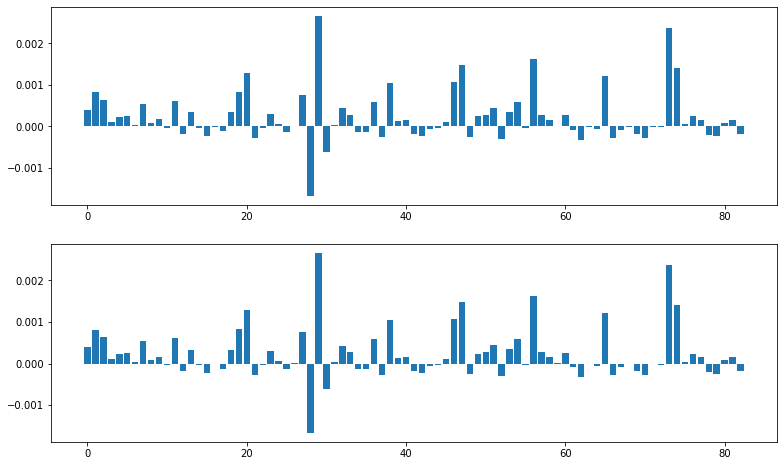

In [27]:
plt.figure(figsize=(13,8))
plt.subplot(2,1,1)
plt.bar(x = list(range(error_train.shape[1] )), height =  error_train.mean(axis = 0))
plt.subplot(2,1,2)
plt.bar(x = list(range(error_test.shape[1] )), height =  error_test.mean(axis = 0))
plt.show()

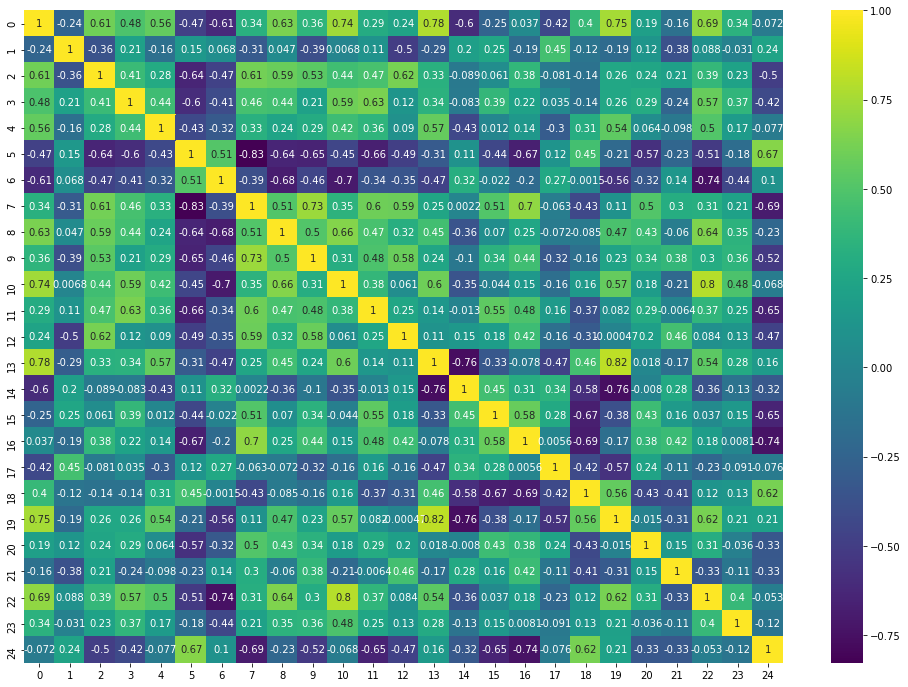

In [28]:
import seaborn as sns
df_encoded = pd.DataFrame(encoded_data_train, columns = list(range(encoded_data_train.shape[1] )) )
figure = plt.figure(figsize=(17,12))
corrMatrix = df_encoded.corr()
sns.heatmap(corrMatrix, annot=True, cbar = True, cmap="viridis")
plt.show()

## Test Features

In [29]:
params= {'colsample_bytree': 0.8937399605148961,
         'early_stopping_rounds': 12,
         'max_depth': 5,
         'min_child_weight': 5,
         'n_estimators': 729,
         'reg_alpha': 19.86313897722475,
         'reg_lambda': 188.1727458353706
        }

fit_params={}
fit_params['early_stopping_rounds'] = params.pop('early_stopping_rounds')

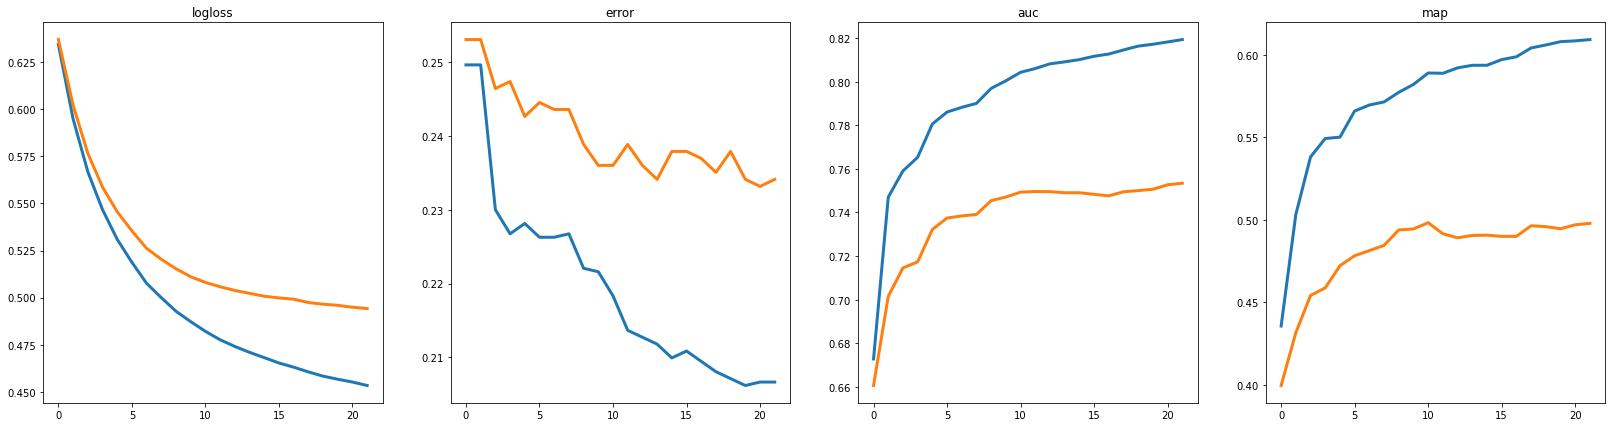

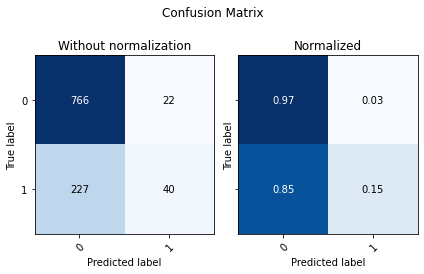

In [30]:
import xgboost as xgb

clf = xgb.XGBClassifier(tree_method = 'gpu_hist', **params)

eval_set = [(encoded_data_train, y_train), (encoded_data_test, y_test)]

clf.fit(encoded_data_train, y_train,  eval_metric=["logloss","error", "auc", "map"], 
        eval_set=eval_set, verbose=False, **fit_params);

keys = clf.evals_result()['validation_0'].keys()

fig, ax = plt.subplots( 1, len(keys), figsize = (7*len(keys),7))
ax = ax.ravel()
for i, key in enumerate(keys):
    ax[i].set_title(key)
    ax[i].plot(clf.evals_result()['validation_0'][key], lw = 3)
    ax[i].plot(clf.evals_result()['validation_1'][key], lw = 3)
plt.show()

y_pred = clf.predict(encoded_data_test)
plot_confusion_matrix(y_test, y_pred, ['0', '1'])

In [31]:
evaluate = (y_test, y_pred)
print('f1_score: ', f1_score(*evaluate))
print('Accuracy: ', accuracy_score(*evaluate))
print('Precision: ', precision_score(*evaluate))
print('Recall: ', recall_score(*evaluate))

f1_score:  0.24316109422492402
Accuracy:  0.7639810426540284
Precision:  0.6451612903225806
Recall:  0.149812734082397


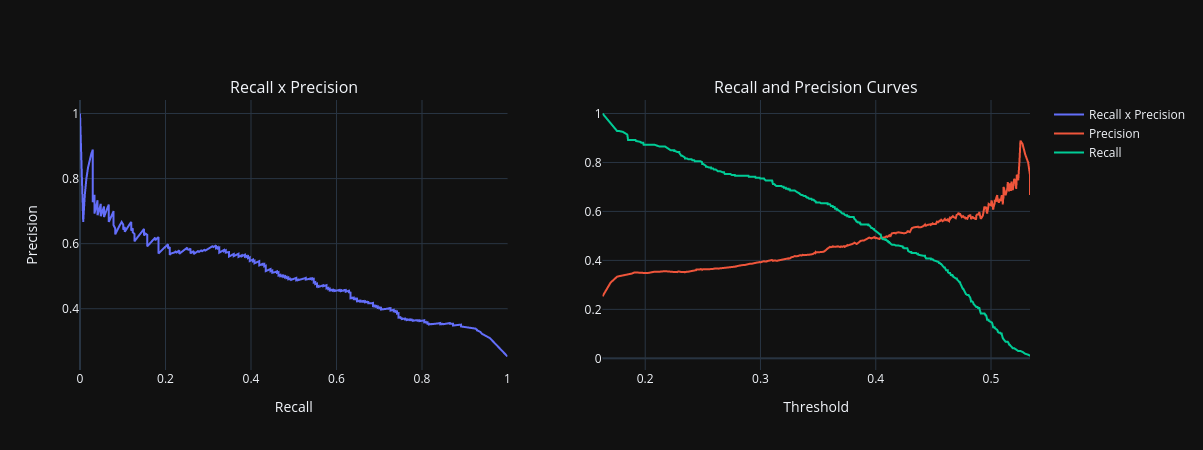

In [32]:

y_pred_prob = clf.predict_proba(encoded_data_test)
fig = plot_precision_recall(y_test, y_pred_prob[:,1])
fig.update_layout(template = 'plotly_dark')
fig.show()

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
           ]


In [34]:

model = Sequential()
model.add(Dense(20, input_dim=encoded_data_train.shape[1],
                activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)


In [35]:
history = model.fit(encoded_data_train, y_train, epochs=150, batch_size=10, 
                    validation_data=(encoded_data_test, y_test))

Epoch 1/150
214/214 [==============================] - 1s 7ms/step - loss: 0.6071 - tp: 115.0000 - fp: 275.0000 - tn: 1330.0000 - fn: 419.0000 - accuracy: 0.6755 - precision: 0.2949 - recall: 0.2154 - auc: 0.5778 - val_loss: 0.5038 - val_tp: 4.0000 - val_fp: 3.0000 - val_tn: 785.0000 - val_fn: 263.0000 - val_accuracy: 0.7479 - val_precision: 0.5714 - val_recall: 0.0150 - val_auc: 0.7331
Epoch 2/150
214/214 [==============================] - 1s 4ms/step - loss: 0.4843 - tp: 43.0000 - fp: 31.0000 - tn: 1574.0000 - fn: 491.0000 - accuracy: 0.7560 - precision: 0.5811 - recall: 0.0805 - auc: 0.7578 - val_loss: 0.4910 - val_tp: 25.0000 - val_fp: 9.0000 - val_tn: 779.0000 - val_fn: 242.0000 - val_accuracy: 0.7621 - val_precision: 0.7353 - val_recall: 0.0936 - val_auc: 0.7492
Epoch 3/150
214/214 [==============================] - 1s 3ms/step - loss: 0.4691 - tp: 98.0000 - fp: 70.0000 - tn: 1535.0000 - fn: 436.0000 - accuracy: 0.7634 - precision: 0.5833 - recall: 0.1835 - auc: 0.7781 - val_loss

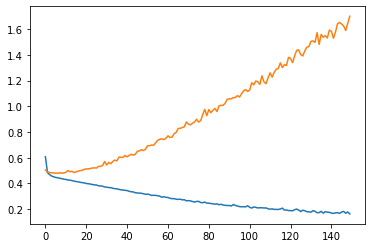

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

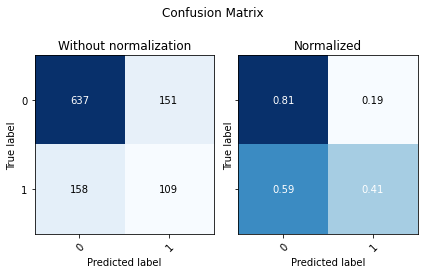

In [37]:
y_pred = (model.predict(encoded_data_test) > 0.5 ).astype(int)
plot_confusion_matrix(y_test, y_pred, ['0', '1'])

In [38]:
total = encoded_data_train.shape[0]
pos = np.unique(y_train, return_counts=True)[1][1]
neg = np.unique(y_train, return_counts=True)[1][0]

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weights = {0: weight_for_0, 1: weight_for_1}

In [51]:
model = Sequential()

model.add(Dense(20, input_dim=encoded_data_train.shape[1], activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

history = model.fit(encoded_data_train, y_train, epochs=150, batch_size=10, 
                    validation_data=(encoded_data_test, y_test), class_weight = class_weights)

Epoch 1/150
214/214 [==============================] - 1s 7ms/step - loss: 0.7050 - tp: 191.0000 - fp: 519.0000 - tn: 1874.0000 - fn: 610.0000 - accuracy: 0.6465 - precision: 0.2690 - recall: 0.2385 - auc: 0.5240 - val_loss: 0.6884 - val_tp: 23.0000 - val_fp: 41.0000 - val_tn: 747.0000 - val_fn: 244.0000 - val_accuracy: 0.7299 - val_precision: 0.3594 - val_recall: 0.0861 - val_auc: 0.5127
Epoch 2/150
214/214 [==============================] - 1s 4ms/step - loss: 0.6925 - tp: 102.0000 - fp: 227.0000 - tn: 1378.0000 - fn: 432.0000 - accuracy: 0.6919 - precision: 0.3100 - recall: 0.1910 - auc: 0.5125 - val_loss: 0.6877 - val_tp: 38.0000 - val_fp: 59.0000 - val_tn: 729.0000 - val_fn: 229.0000 - val_accuracy: 0.7270 - val_precision: 0.3918 - val_recall: 0.1423 - val_auc: 0.5373
Epoch 3/150
214/214 [==============================] - 1s 4ms/step - loss: 0.6909 - tp: 90.0000 - fp: 210.0000 - tn: 1395.0000 - fn: 444.0000 - accuracy: 0.6942 - precision: 0.3000 - recall: 0.1685 - auc: 0.5038 - va

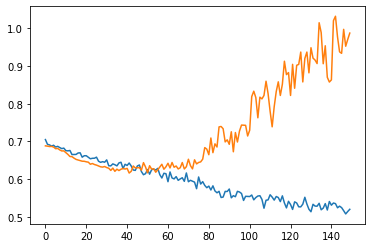

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

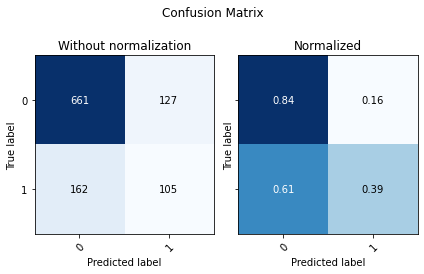

In [53]:
y_pred_prob = model.predict(encoded_data_test)
y_pred = (y_pred_prob  > 0.5 ).astype(int)
plot_confusion_matrix(y_test, y_pred, ['0', '1'])

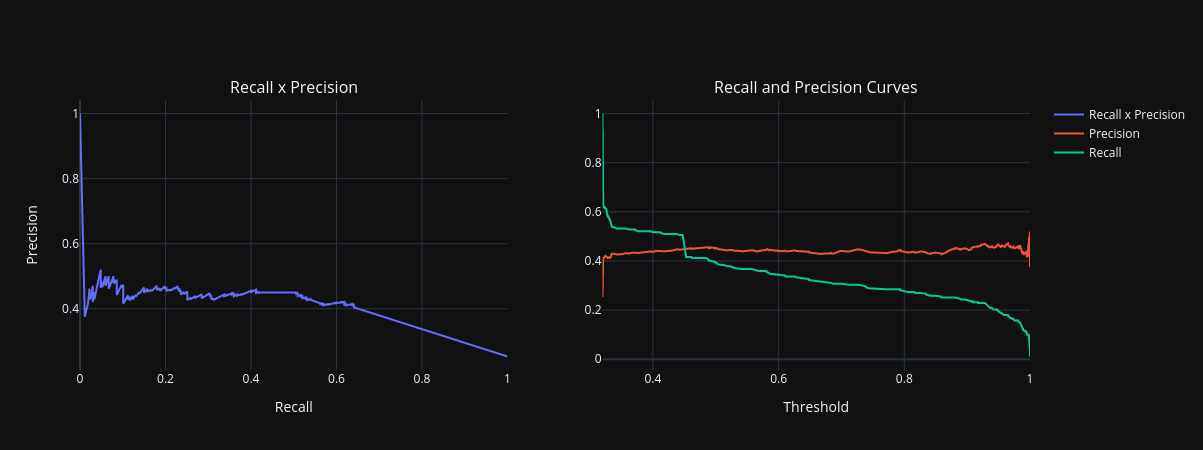

In [54]:
fig = plot_precision_recall(y_test, y_pred_prob)
fig.update_layout(template = 'plotly_dark')
fig.show()

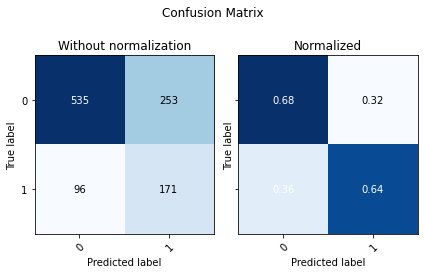

f1_score:  0.49493487698986977
Accuracy:  0.6691943127962086
Precision:  0.4033018867924528
Recall:  0.6404494382022472


In [55]:
desired_recall = 0.8

precision, recall, threshold = precision_recall_curve(y_test, y_pred_prob)
y_pred_threshold = (y_pred_prob > threshold[arg_nearest(recall, desired_recall)]).astype(int)

plot_confusion_matrix(y_test, y_pred_threshold, ['0','1'])
evaluate = (y_test, y_pred_threshold)
print('f1_score: ', f1_score(*evaluate))
print('Accuracy: ', accuracy_score(*evaluate))
print('Precision: ', precision_score(*evaluate))
print('Recall: ', recall_score(*evaluate))